In [1]:
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, preprocessing
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,roc_auc_score,roc_curve, precision_recall_curve, average_precision_score, auc
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz, DecisionTreeClassifier
import datetime as dt
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
import statsmodels.stats.api as sms
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader, Dataset

## Load dataset

In [2]:
path = "example_dataset.csv"
df_all = pd.read_csv(path, index_col=0)
df_all

## Define helper functions

In [4]:
def calculate_ns_probs(y_test):
	return [0 for _ in range(len(y_test))]

def calculate_ns_auc(y_test,ns_probs):
	return roc_auc_score(y_test, ns_probs)

def calculate_lr_auc(y_test,lr_probs):
	return roc_auc_score(y_test, lr_probs)

def calculate_ns_roc_curve(y_test,ns_probs):
	return roc_curve(y_test,ns_probs)

def calculate_lr_roc_curve(y_test,lr_probs):
	return roc_curve(y_test,lr_probs)

def calculate_threshold(lr_tpr,lr_fpr, lr_thresholds):
	# Calculate the G-mean
	gmean= np.sqrt(lr_tpr * (1 - lr_fpr))
	# Calculate the Youden's J Statistic
	youdenJ = lr_tpr - lr_fpr
	# Find the optimal threshold
	index = np.argmax(youdenJ)
	thresholdOpt = lr_thresholds[index]
	thresholdOpt = round(lr_thresholds[index], ndigits = 4)
	return thresholdOpt


def calculate_youdenJ(lr_tpr,lr_fpr, lr_thresholds):
	# Calculate the G-mean
	gmean= np.sqrt(lr_tpr * (1 - lr_fpr))
	# Calculate the Youden's J Statistic
	youdenJ = lr_tpr - lr_fpr
	# Find the optimal threshold
	index = np.argmax(youdenJ)
	thresholdOpt = lr_thresholds[index]
	thresholdOpt = round(lr_thresholds[index], ndigits = 4)
	youdenJOpt = round(gmean[index], ndigits = 4)
	return youdenJOpt

def calculate_index(lr_tpr, lr_fpr):
	# Calculate the G-mean
	gmean= np.sqrt(lr_tpr * (1 - lr_fpr))
	# Calculate the Youden's J Statistic
	youdenJ = lr_tpr - lr_fpr
	# Find the optimal threshold
	index = np.argmax(youdenJ)
	return index

def calculate_f1_score(recall,precision):
    numerator = 2 * recall * precision
    denom = recall + precision
    #f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
    return numerator/denom

In [5]:
def bootstrap(data, iterations, alpha, lr_probs,y_pred, select_roc_f1, index_f):
    sample_size=len(data)
        
    roc_score = []
    f1_score = []
    rand_stat=np.random.RandomState(10)
    
    ind=np.arange(0,sample_size)
    
    
    for it in range(iterations):
        #Resample index
        index=resample(ind,n_samples=sample_size)
        
        sample_iteration=data.iloc[index]
        lr_probs_iteration=lr_probs[index]
        y_pred_iteration=y_pred[index]
        
        if select_roc_f1=='roc_auc':
            # incorporate into sample & lr_probs
            roc_score_val = roc_auc_score(sample_iteration,lr_probs_iteration)
            roc_score.append(roc_score_val)
        
        else:
            lr_precision, lr_recall, thresholds = precision_recall_curve(sample_iteration, lr_probs_iteration)

            recall=lr_recall[index_f]
            precision=lr_precision[index_f]
            f1_score_val= calculate_f1_score(recall,precision)
            f1_score.append(f1_score_val)
    
    
    lower_p = ((1.0-alpha)/2.0) * 100
    upper_p = (alpha+((1.0-alpha)/2.0)) * 100
    if select_roc_f1=='roc_auc':
        roc_score_array=np.array(roc_score)
        roc_score_array.sort()

        
        lower_roc = max(0.0, np.percentile(roc_score_array, lower_p))
        upper_roc = min(1.0, np.percentile(roc_score_array, upper_p))

        return_string='Alpha %.1f%% ROC confidence interval %.1f%% and %.1f%%' % (alpha*100, lower_roc*100, upper_roc*100)
        return ('(%.3f, %.3f)' % (lower_roc,upper_roc))
    
    else:
        f1_score_array = np.array(f1_score)
        f1_score_array.sort()

        lower_f1 = max(0.0, np.percentile(f1_score_array, lower_p))
        upper_f1 = min(1.0, np.percentile(f1_score_array, upper_p))

        return_string=(' f1 confidence interval %.1f%% and %.1f%%' % (lower_f1*100, upper_f1*100))
        return ('(%.3f, %.3f)' % (lower_f1,upper_f1))


In [6]:
## DeLong AUC comparison test helper functions

def compute_midrank(x):
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # because python uses 0 indexing
    T2[J] = T + 1
    return T2


def compute_midrank_weight(x, sample_weight):
    J = np.argsort(x)
    Z = x[J]
    cumulative_weight = np.cumsum(sample_weight[J])
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = cumulative_weight[i:j].mean()
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T
    return T2

"""
Reference:
 @article{sun2014fast,
   title={Fast Implementation of DeLong's Algorithm for
          Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
   author={Xu Sun and Weichao Xu},
   journal={IEEE Signal Processing Letters},
   volume={21},
   number={11},
   pages={1389--1393},
   year={2014},
   publisher={IEEE}
 }
"""
def fastDeLong(predictions_sorted_transposed, label_1_count):
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov

def fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight):
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank_weight(positive_examples[r, :], sample_weight[:m])
        ty[r, :] = compute_midrank_weight(negative_examples[r, :], sample_weight[m:])
        tz[r, :] = compute_midrank_weight(predictions_sorted_transposed[r, :], sample_weight)
    total_positive_weights = sample_weight[:m].sum()
    total_negative_weights = sample_weight[m:].sum()
    pair_weights = np.dot(sample_weight[:m, np.newaxis], sample_weight[np.newaxis, m:])
    total_pair_weights = pair_weights.sum()
    aucs = (sample_weight[:m]*(tz[:, :m] - tx)).sum(axis=1) / total_pair_weights
    v01 = (tz[:, :m] - tx[:, :]) / total_negative_weights
    v10 = 1. - (tz[:, m:] - ty[:, :]) / total_positive_weights
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def fastDeLong_no_weights(predictions_sorted_transposed, label_1_count):
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count

def delong_roc_variance(ground_truth, predictions, sample_weight=None):
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "AUC array has only one element"
    return aucs[0], delongcov

def delong_roc_test(ground_truth, predictions_one, predictions_two):
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)

def my_delong_test(y_true, y_pred, alpha):
    auc, auc_cov = delong_roc_variance(y_true, y_pred)

    auc_std = np.sqrt(auc_cov)
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

    ci = stats.norm.ppf(lower_upper_q, loc=auc, scale=auc_std)

    ci[ci > 1] = 1

    return auc, ci

alpha = 0.95

## Random Forest  Model

In [3]:
## roughly 80-20 split based on date
split_date = dt.datetime(2020, 6, 1)
df_all['HospitalAdmissionTime'] = pd.to_datetime(df_all['HospitalAdmissionTime'],format='%Y-%m-%d')
train_df = df_all.loc[(df_all['HospitalAdmissionTime'] <= split_date)]
test_df = df_all.loc[(df_all['HospitalAdmissionTime'] > split_date)]

train_df.drop(['HospitalAdmissionTime'], axis=1, inplace = True)
train_df = train_df.fillna(0)

test_df.drop(['HospitalAdmissionTime'], axis=1, inplace = True)
test_df = test_df.fillna(0)

X_train = train_df.loc[:, train_df.columns != 'ExpiredStatus']
y_train = train_df.loc[:, train_df.columns == 'ExpiredStatus']

X_test = test_df.loc[:, test_df.columns != 'ExpiredStatus']
y_test = test_df.loc[:, test_df.columns == 'ExpiredStatus']

print("Training Shape before ", X_train.shape, y_train.shape)

train_df = pd.merge(X_train, y_train, left_index=True, right_index=True)
# print(new_train_df)

print('train')
print(train_df['ExpiredStatus'].value_counts())

print('test')
print(test_df['ExpiredStatus'].value_counts())

In [5]:
#Create a simple Gaussian Classifier
clf_rand_forest=RandomForestClassifier(n_estimators=256,max_depth=1000, bootstrap=True, max_features='auto', min_samples_split = 10)

#Train the model using the training sets
clf_rand_forest.fit(X_train,y_train)

y_pred_rand_forest=clf_rand_forest.predict(X_test)

score_rand_forest = metrics.accuracy_score(y_test, y_pred_rand_forest)
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred_rand_forest)*100,2),'%')

# predict probabilities
ns_probs_rand_forest = calculate_ns_probs(y_test)
lr_probs_rand_forest = clf_rand_forest.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs_rand_forest = lr_probs_rand_forest[:, 1]
# calculate scores
ns_auc_rand_forest = calculate_ns_auc(y_test, ns_probs_rand_forest)
lr_auc_rand_forest = calculate_lr_auc(y_test, lr_probs_rand_forest)

# summarize scores
print('Baseline: ROC AUC=%.3f' % (ns_auc_rand_forest))
print('Rand: ROC AUC=%.3f' % (lr_auc_rand_forest))

# calculate roc curves
ns_fpr_rand_forest, ns_tpr_rand_forest, thresholds_rand_forest = calculate_ns_roc_curve(y_test, ns_probs_rand_forest)
lr_fpr_rand_forest, lr_tpr_rand_forest, lr_thresholds_rand_forest = calculate_lr_roc_curve(y_test, lr_probs_rand_forest)

In [6]:
#Calculate AUC 
y_test_arr = np.squeeze(y_test.values)
auc_rand_forest, delong_rand_forest = my_delong_test(y_test_arr, lr_probs_rand_forest, alpha)
print(auc_rand_forest, delong_rand_forest)

In [7]:
#Find best threshold for precision-recall with Youden J statistics
thresholdOpt_rand_forest = calculate_threshold(lr_tpr_rand_forest, lr_fpr_rand_forest, lr_thresholds_rand_forest)
print(thresholdOpt_rand_forest)

youdenJOpt_rand_forest=calculate_youdenJ(lr_tpr_rand_forest, lr_fpr_rand_forest, lr_thresholds_rand_forest)
print(youdenJOpt_rand_forest)

index_rand_forest=calculate_index(lr_tpr_rand_forest,lr_fpr_rand_forest)
fprOpt_rand_forest = round(lr_fpr_rand_forest[index_rand_forest], ndigits = 4)
tprOpt_rand_forest = round(lr_tpr_rand_forest[index_rand_forest], ndigits = 4)

print('Best Threshold: {} with Youden J statistic: {}'.format(thresholdOpt_rand_forest, youdenJOpt_rand_forest))
print('FPR: {}, TPR: {}'.format(fprOpt_rand_forest, tprOpt_rand_forest))
results_text_rand_forest='Sens: ' + str(tprOpt_rand_forest) + ', Spec: '+ str(1-fprOpt_rand_forest)
print(results_text_rand_forest)

# predict class values
yhat_rand_forest = clf_rand_forest.predict(X_test)
lr_precision_rand_forest, lr_recall_rand_forest, _ = precision_recall_curve(y_test, lr_probs_rand_forest)

In [8]:
#Calculate f1
recall=lr_recall_rand_forest[index_rand_forest]
precision=lr_precision_rand_forest[index_rand_forest]
f1_rand_forest= calculate_f1_score(recall,precision)
print('Random Forest f1: '+ str(round(f1_rand_forest,3)))

## XGBoost Model

In [9]:
for col in train_df.columns.values:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)
X_train = train_df.loc[:, train_df.columns != 'ExpiredStatus']
X_test = test_df.loc[:, test_df.columns != 'ExpiredStatus']
y_train = train_df['ExpiredStatus']
y_test = test_df['ExpiredStatus']

clf_xgboost = XGBClassifier(objective='binary:logistic', learning_rate = 0.1, max_depth = 6, n_estimators = 300)
clf_xgboost.fit(X_train, y_train)
y_pred_xgboost = clf_xgboost.predict(X_test)

accuracy_xgboost = metrics.accuracy_score(y_test, y_pred_xgboost)
print("Accuracy: %.6f%%" % (accuracy_xgboost * 100))

# predict probabilities
ns_probs_xgboost = [0 for _ in range(len(y_test))]
lr_probs_xgboost = clf_xgboost.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs_xgboost = lr_probs_xgboost[:, 1]
# calculate scores
ns_auc_xgboost = roc_auc_score(y_test, ns_probs_xgboost)
lr_auc_xgboost = roc_auc_score(y_test, lr_probs_xgboost)
xgboost_auc=lr_auc_xgboost
# summarize scores
print('Baseline: ROC AUC=%.3f' % (ns_auc_xgboost))
print('xgBoost: ROC AUC=%.3f' % (xgboost_auc))
# calculate roc curves
ns_fpr_xgboost, ns_tpr_xgboost, thresholds_xgboost = roc_curve(y_test, ns_probs_xgboost)
lr_fpr_xgboost, lr_tpr_xgboost, lr_thresholds_xgboost = roc_curve(y_test, lr_probs_xgboost)

In [10]:
auc_xgb, delong_xgb = my_delong_test(y_test_arr, lr_probs_xgboost, alpha)
print(auc_xgb, delong_xgb)

In [11]:
thresholdOpt_xgboost = calculate_threshold(lr_tpr_xgboost, lr_fpr_xgboost, lr_thresholds_xgboost)
print(thresholdOpt_xgboost)

youdenJOpt_xgboost=calculate_youdenJ(lr_tpr_xgboost, lr_fpr_xgboost, lr_thresholds_xgboost)
print(youdenJOpt_xgboost)

index_xgboost=calculate_index(lr_tpr_xgboost,lr_fpr_xgboost)
fprOpt_xgboost = round(lr_fpr_xgboost[index_xgboost], ndigits = 4)
tprOpt_xgboost = round(lr_tpr_xgboost[index_xgboost], ndigits = 4)

print('Best Threshold: {} with Youden J statistic: {}'.format(thresholdOpt_xgboost, youdenJOpt_xgboost))
print('FPR: {}, TPR: {}'.format(fprOpt_xgboost, tprOpt_xgboost))
results_text_xgboost='Sens: ' + str(round(tprOpt_xgboost,3)) + ', Spec: '+ str(round(1-fprOpt_xgboost,3))
print(results_text_xgboost)

# # Print f1
# f1_xgboost= round((metrics.f1_score(y_test,y_pred_xgboost)),3)
# print('xgboost f1: '+ str(round(f1_xgboost,3)))

# predict class values
yhat_xgboost = clf_xgboost.predict(X_test)
lr_precision_xgboost, lr_recall_xgboost, _ = precision_recall_curve(y_test, lr_probs_xgboost)

In [ ]:
recall=lr_recall_xgboost[index_xgboost]
precision=lr_precision_xgboost[index_xgboost]
f1_xgboost= calculate_f1_score(recall,precision)
print('xgboost f1: '+ str(round(f1_xgboost,3)))

## Logistic Regression Model

In [12]:
### BASIC LOGISTIC REGRESSION
X_train = train_df.loc[:, train_df.columns != 'ExpiredStatus']
X_test = test_df.loc[:, test_df.columns != 'ExpiredStatus']
y_train = train_df['ExpiredStatus']
y_test = test_df['ExpiredStatus']

np.any(np.isnan(X_train))
np.all(np.isfinite(X_train))

##using solver saga, handles multinomial loss with L1 penalty
model_basic_regression = LogisticRegression(solver='saga')
model_basic_regression.fit(X_train, y_train)
preds_basic_regression = model_basic_regression.predict(X_test)

score_basic_regression = metrics.accuracy_score(y_test, preds_basic_regression)
print("Accuracy:",round(metrics.accuracy_score(y_test, preds_basic_regression)*100,2),'%')

coef_basic_regression = model_basic_regression.coef_[0]

score_basic_regression = model_basic_regression.score(X_test, y_test)
print("Using saga solver: " + str(round(score_basic_regression,2)*100),'%')

In [13]:
# predict probabilities
ns_probs_basic_regression = [0 for _ in range(len(y_test))]
lr_probs_basic_regression = model_basic_regression.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs_basic_regression = lr_probs_basic_regression[:, 1]
# calculate scores
ns_auc_basic_regression = roc_auc_score(y_test, ns_probs_basic_regression)
lr_auc_basic_regression = roc_auc_score(y_test, lr_probs_basic_regression)
logistic_auc=lr_auc_basic_regression
# summarize scores
print('Baseline: ROC AUC=%.3f' % (ns_auc_basic_regression))
print('Logistic: ROC AUC=%.3f' % (logistic_auc))
# calculate roc curves
ns_fpr_basic_regression, ns_tpr_basic_regression, thresholds_basic_regression = roc_curve(y_test, ns_probs_basic_regression)
lr_fpr_basic_regression, lr_tpr_basic_regression, lr_thresholds_basic_regression = roc_curve(y_test, lr_probs_basic_regression)


In [ ]:
auc_reg, delong_reg = my_delong_test(y_test_arr, lr_probs_basic_regression, alpha)
print(auc_reg, delong_reg)

In [ ]:
thresholdOpt_basic_regression = calculate_threshold(lr_tpr_basic_regression, lr_fpr_basic_regression, lr_thresholds_basic_regression)
print(thresholdOpt_basic_regression)

youdenJOpt_basic_regression=calculate_youdenJ(lr_tpr_basic_regression, lr_fpr_basic_regression, lr_thresholds_basic_regression)
print(youdenJOpt_basic_regression)

index_basic_regression=calculate_index(lr_tpr_basic_regression,lr_fpr_basic_regression)
fprOpt_basic_regression = round(lr_fpr_basic_regression[index_basic_regression], ndigits = 4)
tprOpt_basic_regression = round(lr_tpr_basic_regression[index_basic_regression], ndigits = 4)

print('Best Threshold: {} with Youden J statistic: {}'.format(thresholdOpt_basic_regression, youdenJOpt_basic_regression))
print('FPR: {}, TPR: {}'.format(fprOpt_basic_regression, tprOpt_basic_regression))

# confusion matrix 
y_pred_basic_regression = (model_basic_regression.predict_proba(X_test)[:,1]>thresholdOpt_basic_regression).astype('float')
cm_basic_regression = metrics.confusion_matrix(y_test, preds_basic_regression) 
#print ("Confusion Matrix : \n", cm_basic_regression)

results_text_basic_regression='Sens: ' + str(round(tprOpt_basic_regression,3)) + ', Spec: '+ str(round(1-fprOpt_basic_regression,3))
print(results_text_basic_regression)

# # Print f1
# f1_basic_regression= round((metrics.f1_score(y_test,y_pred_basic_regression)),3)
# print('Logistic Regression f1: '+ str(round(f1_basic_regression,3)))

# predict class values
yhat_basic_regression = model_basic_regression.predict(X_test)
lr_precision_basic_regression, lr_recall_basic_regression, thresholds_basic_regression = precision_recall_curve(y_test, lr_probs_basic_regression)

In [14]:
recall=lr_recall_basic_regression[index_basic_regression]
precision=lr_precision_basic_regression[index_basic_regression]
f1_basic_regression= calculate_f1_score(recall,precision)
print('Logistic Regression f1: '+ str(round(f1_basic_regression,3)))

## ADHERE

In [ ]:
adhere_score=pd.read_csv("adhere_score.csv")

adhere_score.drop(['ef_category','ef_low'],axis=1,inplace=True)

adhere_score.columns.unique()

#adhere_score=adhere_score[adhere_score['code_blue']!=0]
adhere_score['ExpiredStatus'].replace('Not Expired',0, inplace=True)
adhere_score['ExpiredStatus'].replace('Expired',1, inplace=True)
adhere_score['ExpiredStatus'].value_counts()

# Adhere Score Random Forest

split_date = dt.datetime(2020, 6, 1)
adhere_score['HospitalAdmissionTime'] = pd.to_datetime(adhere_score['HospitalAdmissionTime'],format='%Y-%m-%d')

adhere_score['adhere_score_0'].value_counts()

In [15]:
# Adhere Score
train_df_adhere_score_basic_regression = adhere_score.loc[(adhere_score['HospitalAdmissionTime'] <= split_date)]
test_df_adhere_score_basic_regression = adhere_score.loc[(adhere_score['HospitalAdmissionTime'] > split_date)]

train_df_adhere_score_basic_regression.drop(['HospitalAdmissionTime'], axis=1, inplace = True)
train_df_adhere_score_basic_regression = train_df_adhere_score_basic_regression.fillna(0)

test_df_adhere_score_basic_regression.drop(['HospitalAdmissionTime'], axis=1, inplace = True)
test_df_adhere_score_basic_regression = test_df_adhere_score_basic_regression.fillna(0)

X_train_adhere_score_basic_regression= train_df_adhere_score_basic_regression.loc[:, train_df_adhere_score_basic_regression.columns != 'ExpiredStatus']
X_test_adhere_score_basic_regression = test_df_adhere_score_basic_regression.loc[:, test_df_adhere_score_basic_regression.columns != 'ExpiredStatus']
y_train_adhere_score_basic_regression= train_df_adhere_score_basic_regression['ExpiredStatus']
y_test_adhere_score_basic_regression = test_df_adhere_score_basic_regression['ExpiredStatus']

X_test_temp=np.where(X_test_adhere_score_basic_regression['adhere_score_0']<0.5, 0,1)
y_pred_adhere_score_basic_regression=X_test_temp

score_adhere_score_basic_regression = metrics.accuracy_score(y_test_adhere_score_basic_regression, y_pred_adhere_score_basic_regression)
print("Accuracy:",round(metrics.accuracy_score(y_test_adhere_score_basic_regression, y_pred_adhere_score_basic_regression)*100,2),'%')


In [28]:
# predict probabilities
ns_probs_adhere_score_basic_regression = [0 for _ in range(len(y_test_adhere_score_basic_regression))]
lr_probs_adhere_score_basic_regression = X_test_adhere_score_basic_regression

# keep probabilities for the positive outcome only
#lr_probs_adhere_score_basic_regression = lr_probs_adhere_score_basic_regression[:, 1]

# calculate scores
ns_auc_adhere_score_basic_regression = roc_auc_score(y_test_adhere_score_basic_regression, ns_probs_adhere_score_basic_regression)
lr_auc_adhere_score_basic_regression = roc_auc_score(y_test_adhere_score_basic_regression, lr_probs_adhere_score_basic_regression)

# calculate roc curves
ns_fpr_adhere_score_basic_regression, ns_tpr_adhere_score_basic_regression, thresholds_adhere_score_basic_regression = roc_curve(y_test_adhere_score_basic_regression, ns_probs_adhere_score_basic_regression)
lr_fpr_adhere_score_basic_regression, lr_tpr_adhere_score_basic_regression, lr_thresholds_adhere_score_basic_regression = roc_curve(y_test_adhere_score_basic_regression, lr_probs_adhere_score_basic_regression)

In [ ]:
auc_adhere, delong_adhere = my_delong_test(y_test_arr, lr_probs_adhere_score_basic_regression['adhere_score_0'], alpha)
print(auc_adhere, delong_adhere)

In [16]:
thresholdOpt_adhere_score_basic_regression = calculate_threshold(lr_tpr_adhere_score_basic_regression, lr_fpr_adhere_score_basic_regression, lr_thresholds_adhere_score_basic_regression)
print(thresholdOpt_adhere_score_basic_regression)

youdenJOpt_adhere_score_basic_regression=calculate_youdenJ(lr_tpr_adhere_score_basic_regression, lr_fpr_adhere_score_basic_regression, lr_thresholds_adhere_score_basic_regression)
print(youdenJOpt_adhere_score_basic_regression)

index_adhere_score_basic_regression=calculate_index(lr_tpr_adhere_score_basic_regression,lr_fpr_adhere_score_basic_regression)
fprOpt_adhere_score_basic_regression = round(lr_fpr_adhere_score_basic_regression[index_adhere_score_basic_regression], ndigits = 4)
tprOpt_adhere_score_basic_regression = round(lr_tpr_adhere_score_basic_regression[index_adhere_score_basic_regression], ndigits = 4)

print('Best Threshold: {} with Youden J statistic: {}'.format(thresholdOpt_adhere_score_basic_regression, youdenJOpt_adhere_score_basic_regression))
print('FPR: {}, TPR: {}'.format(fprOpt_adhere_score_basic_regression, tprOpt_adhere_score_basic_regression))
results_text_adhere_score_basic_regression=('Sens: ' + str(round(tprOpt_adhere_score_basic_regression,3)) 
                                            + ', Spec: '+ str(round(1-fprOpt_adhere_score_basic_regression,3)))
print(results_text_adhere_score_basic_regression)


cm_adhere_score_basic_regression = confusion_matrix(y_test_adhere_score_basic_regression, y_pred_adhere_score_basic_regression) 

#yhat_adhere_score_basic_regression = #clf_adhere_score_basic_regression.predict(X_test_adhere_score_basic_regression)
lr_precision_adhere_score_basic_regression, lr_recall_adhere_score_basic_regression, _ = precision_recall_curve(y_test_adhere_score_basic_regression, lr_probs_adhere_score_basic_regression)

#yhat_adhere_score_basic_regression = clf_adhere_score_basic_regression.predict(X_test_adhere_score_basic_regression)
lr_precision_adhere_score_basic_regression, lr_recall_adhere_score_basic_regression, thresholds_adhere_score_basic_regression = precision_recall_curve(y_test_adhere_score_basic_regression, lr_probs_adhere_score_basic_regression)


In [ ]:
recall=lr_recall_adhere_score_basic_regression[index_adhere_score_basic_regression]
precision=lr_precision_adhere_score_basic_regression[index_adhere_score_basic_regression]
f1_adhere_score_basic_regression= calculate_f1_score(recall,precision)
print('Adhere Score f1: '+ str(round(f1_adhere_score_basic_regression,3)))

## GWTG_HF

In [ ]:
gwtg_hf_score=pd.read_csv("gwtg_hf_score.csv")
gwtg_hf_score['GWTG_HF_Score_Final'].value_counts()

In [ ]:
gwtg_hf_score.columns.unique()

gwtg_hf_score['ExpiredStatus'].replace('Not Expired',0, inplace=True)
gwtg_hf_score['ExpiredStatus'].replace('Expired',1, inplace=True)
gwtg_hf_score['ExpiredStatus'].value_counts()

gwtg_hf_score_expired_status=gwtg_hf_score['ExpiredStatus']

gwtg_hf_score=gwtg_hf_score.drop(['ef_category','ef_low'],axis=1)

# National Early Adhere Score

split_date = dt.datetime(2020, 6, 1)
gwtg_hf_score['HospitalAdmissionTime'] = pd.to_datetime(gwtg_hf_score['HospitalAdmissionTime'],format='%Y-%m-%d')
train_df_gwtg_hf_score_basic_regression = gwtg_hf_score.loc[(gwtg_hf_score['HospitalAdmissionTime'] <= split_date)]
test_df_gwtg_hf_score_basic_regression = gwtg_hf_score.loc[(gwtg_hf_score['HospitalAdmissionTime'] > split_date)]

train_df_gwtg_hf_score_basic_regression.drop(['HospitalAdmissionTime'], axis=1, inplace = True)
train_df_gwtg_hf_score_basic_regression = train_df_gwtg_hf_score_basic_regression.fillna(0)

test_df_gwtg_hf_score_basic_regression.drop(['HospitalAdmissionTime'], axis=1, inplace = True)
test_df_gwtg_hf_score_basic_regression = test_df_gwtg_hf_score_basic_regression.fillna(0)

print('train')
print(train_df['ExpiredStatus'].value_counts())

print('test_gwtg_hf_score_basic_regression')
print(test_df_gwtg_hf_score_basic_regression['ExpiredStatus'].value_counts())

X_train_gwtg_hf_score_basic_regression= train_df_gwtg_hf_score_basic_regression.loc[:, train_df_gwtg_hf_score_basic_regression.columns != 'ExpiredStatus']
X_test_gwtg_hf_score_basic_regression = test_df_gwtg_hf_score_basic_regression.loc[:, test_df_gwtg_hf_score_basic_regression.columns != 'ExpiredStatus']
y_train_gwtg_hf_score_basic_regression= train_df_gwtg_hf_score_basic_regression['ExpiredStatus']
y_test_gwtg_hf_score_basic_regression = test_df_gwtg_hf_score_basic_regression['ExpiredStatus']

clf_gwtg_hf_score_basic_regression = LogisticRegression(solver='saga')
clf_gwtg_hf_score_basic_regression.fit(X_train_gwtg_hf_score_basic_regression, y_train_gwtg_hf_score_basic_regression)
y_pred_gwtg_hf_score_basic_regression = clf_gwtg_hf_score_basic_regression.predict(X_test_gwtg_hf_score_basic_regression)

score_gwtg_hf_score_basic_regression = metrics.accuracy_score(y_test_gwtg_hf_score_basic_regression, y_pred_gwtg_hf_score_basic_regression)
print("Accuracy:",round(metrics.accuracy_score(y_test_gwtg_hf_score_basic_regression, y_pred_gwtg_hf_score_basic_regression)*100,2),'%')


In [34]:
# predict probabilities
ns_probs_gwtg_hf_score_basic_regression = [0 for _ in range(len(y_test_gwtg_hf_score_basic_regression))]
lr_probs_gwtg_hf_score_basic_regression = clf_gwtg_hf_score_basic_regression.predict_proba(X_test_gwtg_hf_score_basic_regression)
# keep probabilities for the positive outcome only
lr_probs_gwtg_hf_score_basic_regression = lr_probs_gwtg_hf_score_basic_regression[:, 1]
# calculate scores
ns_auc_gwtg_hf_score_basic_regression = roc_auc_score(y_test_gwtg_hf_score_basic_regression, ns_probs_gwtg_hf_score_basic_regression)
lr_auc_gwtg_hf_score_basic_regression = roc_auc_score(y_test_gwtg_hf_score_basic_regression, lr_probs_gwtg_hf_score_basic_regression)

# calculate roc curves
ns_fpr_gwtg_hf_score_basic_regression, ns_tpr_gwtg_hf_score_basic_regression, thresholds_gwtg_hf_score_basic_regression = roc_curve(y_test_gwtg_hf_score_basic_regression, ns_probs_gwtg_hf_score_basic_regression)
lr_fpr_gwtg_hf_score_basic_regression, lr_tpr_gwtg_hf_score_basic_regression, lr_thresholds_gwtg_hf_score_basic_regression = roc_curve(y_test_gwtg_hf_score_basic_regression, lr_probs_gwtg_hf_score_basic_regression)


In [ ]:
auc_gwtg, delong_gwtg = my_delong_test(y_test_arr, lr_probs_gwtg_hf_score_basic_regression, alpha)
print(auc_gwtg, delong_gwtg)

In [ ]:
thresholdOpt_gwtg_hf_score_basic_regression = calculate_threshold(lr_tpr_gwtg_hf_score_basic_regression, lr_fpr_gwtg_hf_score_basic_regression, lr_thresholds_gwtg_hf_score_basic_regression)
print(thresholdOpt_gwtg_hf_score_basic_regression)

youdenJOpt_gwtg_hf_score_basic_regression=calculate_youdenJ(lr_tpr_gwtg_hf_score_basic_regression, lr_fpr_gwtg_hf_score_basic_regression, lr_thresholds_gwtg_hf_score_basic_regression)
print(youdenJOpt_gwtg_hf_score_basic_regression)

index_gwtg_hf_score_basic_regression=calculate_index(lr_tpr_gwtg_hf_score_basic_regression,lr_fpr_gwtg_hf_score_basic_regression)
fprOpt_gwtg_hf_score_basic_regression = round(lr_fpr_gwtg_hf_score_basic_regression[index_gwtg_hf_score_basic_regression], ndigits = 4)
tprOpt_gwtg_hf_score_basic_regression = round(lr_tpr_gwtg_hf_score_basic_regression[index_gwtg_hf_score_basic_regression], ndigits = 4)

print('Best Threshold: {} with Youden J statistic: {}'.format(thresholdOpt_gwtg_hf_score_basic_regression, youdenJOpt_gwtg_hf_score_basic_regression))
print('FPR: {}, TPR: {}'.format(fprOpt_gwtg_hf_score_basic_regression, tprOpt_gwtg_hf_score_basic_regression))
results_text_gwtg_hf_score_basic_regression=('Sens: ' + str(round(tprOpt_gwtg_hf_score_basic_regression,3)) + 
                                             ', Spec: '+ str(round(1-fprOpt_gwtg_hf_score_basic_regression,3)))
print(results_text_gwtg_hf_score_basic_regression)

# Confusion matrix based on threshold
y_pred_gwtg_hf_score_basic_regression = (clf_gwtg_hf_score_basic_regression.predict_proba(X_test_gwtg_hf_score_basic_regression)[:,1]>thresholdOpt_gwtg_hf_score_basic_regression).astype('float')
cm_gwtg_hf_score_basic_regression = confusion_matrix(y_test_gwtg_hf_score_basic_regression, y_pred_gwtg_hf_score_basic_regression) 

# predict class values
lr_precision_gwtg_hf_score_basic_regression, lr_recall_gwtg_hf_score_basic_regression, _ = precision_recall_curve(y_test_gwtg_hf_score_basic_regression, lr_probs_gwtg_hf_score_basic_regression)
lr_precision_gwtg_hf_score_basic_regression, lr_recall_gwtg_hf_score_basic_regression, thresholds_gwtg_hf_score_basic_regression = precision_recall_curve(y_test_gwtg_hf_score_basic_regression, lr_probs_gwtg_hf_score_basic_regression)

In [37]:
# predict class values
lr_precision_gwtg_hf_score_basic_regression, lr_recall_gwtg_hf_score_basic_regression, _ = precision_recall_curve(y_test_gwtg_hf_score_basic_regression, lr_probs_gwtg_hf_score_basic_regression)

lr_precision_gwtg_hf_score_basic_regression, lr_recall_gwtg_hf_score_basic_regression, thresholds_gwtg_hf_score_basic_regression = precision_recall_curve(y_test_gwtg_hf_score_basic_regression, lr_probs_gwtg_hf_score_basic_regression)

recall=lr_recall_gwtg_hf_score_basic_regression[index_gwtg_hf_score_basic_regression]
precision=lr_precision_gwtg_hf_score_basic_regression[index_gwtg_hf_score_basic_regression]
f1_gwtg_hf_score_basic_regression= calculate_f1_score(recall,precision)
print('GWTG score f1: '+ str(round(f1_gwtg_hf_score_basic_regression,3)))


## Neural Network Model

In [17]:
for col in train_df.columns.values:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)
X_train = train_df.loc[:, train_df.columns != 'ExpiredStatus']
X_test = test_df.loc[:, test_df.columns != 'ExpiredStatus']
y_train = train_df['ExpiredStatus']
y_test = test_df['ExpiredStatus']

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

### convert 2D train and test to 3D(patient, 4, 4)
X_train_final = np.zeros((X_train.shape[0],4,4))
for i in range(X_train.shape[0]):
    temp_row = X_train.iloc[i,:].values
    temp_mat = np.zeros((4,4))
#     temp_mat = np.zeros((4,10))
    
    for j in range(4):
        for k in range(4):
            temp_mat[j,k] = temp_row[j*4+k]
            
    X_train_final[i] = temp_mat
print(X_train_final[0])
print(X_train_final.shape)

X_test_final = np.zeros((X_test.shape[0],4,4))
for i in range(X_test.shape[0]):
    temp_row = X_test.iloc[i,:].values
    temp_mat = np.zeros((4,4))
    
    for j in range(4):
        for k in range(4):
            temp_mat[j,k] = temp_row[j*4+k]
            
    X_test_final[i] = temp_mat
print(X_test_final.shape)

print(X_train_final.shape, y_train.shape)
print(X_test_final.shape, y_test.shape)

print(X_train_final[0][0])

X_train_tensors = Variable(torch.Tensor(X_train_final))
X_test_tensors = Variable(torch.Tensor(X_test_final))

y_train_tensors = Variable(torch.Tensor(y_train.to_numpy()))
y_test_tensors = Variable(torch.Tensor(y_test.to_numpy()))

print("Training Shape", X_train_tensors.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors.shape, y_test_tensors.shape) 


In [18]:
###Data loader
class Dataset(Dataset):
    def __init__(self, X,y):
        self.x_data = X
        self.y_data = y
        
    def __len__(self):
        return self.x_data.shape[0]  # required

    def __getitem__(self, idx):
        features = self.x_data[idx, :, :]
        label = self.y_data[idx]
        return features, label


# CNN model: https://blog.paperspace.com/writing-cnns-from-scratch-in-pytorch/
class CNN_model(nn.Module):
    #  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(CNN_model, self).__init__()
        self.conv_layer1 = nn.Conv1d(4,8, kernel_size=2) ###a sliding window of size 4*2 is sliding across the row(ie. the time series)
        self.conv_layer2 = nn.Conv1d(8,16, kernel_size=2)
        self.max_pool1 = nn.MaxPool1d(kernel_size = 2, padding=1)
        
        ##try dropout
#         self.drop_layer = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fclast = nn.Linear(8, num_classes)
    
    def forward(self, x):
        out = self.conv_layer1(x)
#         print(out.size())
        out = self.conv_layer2(out)
#         print(out.size())
        out = self.max_pool1(out)
#         print(out.size())
        
        out = torch.flatten(out, 1)
        out = out.reshape(out.size(0), -1)
        
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        return self.fclast(out)
    
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=8, hidden_size=16, num_layers=num_layers, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=16, hidden_size=32, num_layers=num_layers, batch_first=True)
        
        self.fc1 = nn.Linear(128, 50)
        self.fc2 = nn.Linear(50, 10)
        self.fclast = nn.Linear(10, 1)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        
        h_1 = Variable(torch.zeros(self.num_layers, x.size(0), 16))
        c_1 = Variable(torch.zeros(self.num_layers, x.size(0), 16))
        
        h_2 = Variable(torch.zeros(self.num_layers, x.size(0), 32))
        c_2 = Variable(torch.zeros(self.num_layers, x.size(0), 32))
        
        # Propagate input through LSTM
        lstm_out1, (h_out1, _) = self.lstm1(x, (h_0, c_0))
        lstm_out2, (h_out2, _) = self.lstm2(lstm_out1, (h_1, c_1))
        lstm_out3, (h_out3, _) = self.lstm3(lstm_out2, (h_2, c_2))
        
        #print(h_out3.shape)
        #print(lstm_out2.shape)
        lstm_out = torch.flatten(lstm_out3, start_dim=1) #.view(-1, self.hidden_size)
        
        output = F.relu(self.fc1(lstm_out))
#         print(output.shape)
        output = F.relu(self.fc2(output))
#         print(output.shape)
        return self.fclast(output)


In [ ]:
### train the model
def train(model, train_loader, optimizer):
    model.train() ###tells model it is in training mode
    y_true = []
    y_pred = []
    training_loss = 0
        
    for i in train_loader:
        optimizer.zero_grad() ##zeroing gradient
        
        #LOADING THE DATA IN A BATCH
        data, target = i

        #FORWARD PASS
        output = model(data.float())
        output = torch.sigmoid(output)
        
        #print(output.shape)
        
        output=output.squeeze(1)
        
        #print(output.shape)
        
    
        loss = criterion(output, target)#.unsqueeze(1))
        
        #BACKWARD AND OPTIMIZE
        loss.backward()
        optimizer.step()
        
        # PREDICTIONS 
        pred = np.round(output.detach().numpy())
        target = target.float()
        y_true.extend(target.tolist()) 
        y_pred.extend(pred.reshape(-1).tolist())
        
        training_loss = training_loss + loss
        
    print("Accuracy on training set is" , accuracy_score(y_true,y_pred))
    #return training_loss
    return training_loss, roc_auc_score(y_true, y_pred), average_precision_score(y_true, y_pred)
    
#### test the model
def test(model, test_loader):
    #model in eval mode skips Dropout etc
    model.eval()
    y_true = []
    y_pred = []
    pred_unrounded = []
    
    validation_loss = 0
    
    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i in test_loader:
            
            #LOAD THE DATA IN A BATCH
            data,target = i
            
            # the model on the data
            output = model(data)
#             print(output.shape)
            output = torch.sigmoid(output)
            
            output=output.squeeze(1)
        
            loss = criterion(output, target)#.unsqueeze(1))
                 
            #PREDICTIONS
            pred = np.round(output)
            target = target.float()
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
            pred_unrounded.extend(output.reshape(-1).tolist())
            
            validation_loss = validation_loss + loss
            
    print("Accuracy on test set is" , accuracy_score(y_true,y_pred))
    #return validation_loss
    return validation_loss, roc_auc_score(y_true, y_pred), average_precision_score(y_true, y_pred), y_true, y_pred, pred_unrounded


In [ ]:
num_epochs = 20 #1000 epochs
learning_rate = 0.0001 #1e-8 #0.001 lr

input_size = 4 #number of features
hidden_size = 8 #number of features in hidden state
num_layers = 1 ##num layer is 1 since we explicitly code 3 lstm in model
num_classes = 1
lstm = LSTM(input_size, hidden_size, num_layers)
cnn = CNN_model(num_classes)

criterion = nn.BCEWithLogitsLoss()
optimizer_lstm = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
# Train the model
train_dataset = Dataset(X_train_tensors, y_train_tensors)
test_dataset = Dataset(X_test_tensors, y_test_tensors)

train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True, drop_last=True) ### 10700
test_loader = DataLoader(test_dataset, batch_size=30, shuffle=False, drop_last=False) ### 2053

# print(len(train_loader))
# print(len(test_loader))

train_loss_arr_lstm = np.zeros(num_epochs)
train_auc_arr_lstm = np.zeros(num_epochs)
train_pres_arr_lstm = np.zeros(num_epochs)
val_loss_arr_lstm = np.zeros(num_epochs)
val_auc_arr_lstm = np.zeros(num_epochs)
val_pres_arr_lstm = np.zeros(num_epochs)

y_true_net_lstm = np.zeros(test_df.shape[1])
y_pred_net_lstm = np.zeros(test_df.shape[1])
y_pred_unrounded_lstm = np.zeros(test_df.shape[1])

train_loss_arr_cnn = np.zeros(num_epochs)
train_auc_arr_cnn = np.zeros(num_epochs)
train_pres_arr_cnn = np.zeros(num_epochs)
val_loss_arr_cnn = np.zeros(num_epochs)
val_auc_arr_cnn = np.zeros(num_epochs)
val_pres_arr_cnn = np.zeros(num_epochs)

y_true_net_cnn = np.zeros(test_df.shape[1])
y_pred_net_cnn = np.zeros(test_df.shape[1])
y_pred_unrounded_cnn = np.zeros(test_df.shape[1])

print("\n\n\n LSTM\n")
for epoch in range(num_epochs):
    train_loss_arr_lstm[epoch], train_auc_arr_lstm[epoch], train_pres_arr_lstm[epoch] = train(lstm,train_loader,optimizer_lstm)
    val_loss_arr_lstm[epoch], val_auc_arr_lstm[epoch], val_pres_arr_lstm[epoch], y_true_net_lstm, y_pred_net_lstm, y_pred_unrounded_lstm = test(lstm,test_loader)
    
    print(val_loss_arr_lstm[epoch])
    print("**************************")
    
print("\n\n\n CNN\n")
for epoch in range(num_epochs):    
    train_loss_arr_cnn[epoch], train_auc_arr_cnn[epoch], train_pres_arr_cnn[epoch] = train(cnn,train_loader,optimizer_cnn)
    val_loss_arr_cnn[epoch], val_auc_arr_cnn[epoch], val_pres_arr_cnn[epoch], y_true_net_cnn, y_pred_net_cnn, y_pred_unrounded_cnn = test(cnn,test_loader)
    
    print(val_loss_arr_cnn[epoch])
    print("**************************")

##save the model
torch.save(lstm, "/opt/genomics/commonfilesharePHI/zjawadi/latest/20211001/CNN_mortality_trained_20epoch_lr0.0001")
torch.save(cnn, "/opt/genomics/commonfilesharePHI/zjawadi/latest/20211001/CNN_mortality_trained_20epoch_lr0.0001")


In [41]:
# predict probabilities
ns_probs_net_cnn = [0 for _ in range(len(y_test))]
lr_probs_net_cnn = y_pred_unrounded_cnn
# calculate scores
ns_auc_net_cnn = roc_auc_score(y_test, ns_probs_net_cnn)
lr_auc_net_cnn = roc_auc_score(y_test, lr_probs_net_cnn)

# summarize scores
# calculate roc curves
ns_fpr_net_cnn, ns_tpr_net_cnn, _ = roc_curve(y_test, ns_probs_net_cnn)
lr_fpr_net_cnn, lr_tpr_net_cnn, lr_thresholds_net_cnn = roc_curve(y_test, lr_probs_net_cnn)

In [ ]:
auc_cnn, delong_cnn = my_delong_test(y_test_arr, np.array(lr_probs_net_cnn), alpha)
print(auc_cnn, delong_cnn)

In [ ]:
thresholdOpt_net_cnn = calculate_threshold(lr_tpr_net_cnn, lr_fpr_net_cnn, lr_thresholds_net_cnn)
print(thresholdOpt_net_cnn)

youdenJOpt_net_cnn=calculate_youdenJ(lr_tpr_net_cnn, lr_fpr_net_cnn, lr_thresholds_net_cnn)
print(youdenJOpt_net_cnn)

index_net_cnn=calculate_index(lr_tpr_net_cnn,lr_fpr_net_cnn)
fprOpt_net_cnn = round(lr_fpr_net_cnn[index_net_cnn], ndigits = 4)
tprOpt_net_cnn = round(lr_tpr_net_cnn[index_net_cnn], ndigits = 4)

print('Best Threshold: {} with Youden J statistic: {}'.format(thresholdOpt_net_cnn, youdenJOpt_net_cnn))
print('FPR: {}, TPR: {}'.format(fprOpt_net_cnn, tprOpt_net_cnn))
results_text_net_cnn='Sens: ' + str(round(tprOpt_net_cnn,3)) + ', Spec: '+ str(round(1-fprOpt_net_cnn,3))
print(results_text_net_cnn)

# Print f1
# f1_net_cnn= round(metrics.f1_score(y_test,y_pred_net_cnn),3)
# print('CNN f1: '+ str(round(f1_net_cnn,3)))

lr_precision_net_cnn, lr_recall_net_cnn, _ = precision_recall_curve(y_test, y_pred_unrounded_cnn)
#lr_f1_net_cnn, _ = f1_score(y_test, y_pred_net_cnn), auc(lr_recall_net_cnn,lr_precision_net_cnn)


# predict class values
lr_precision_net_cnn, lr_recall_net_cnn, _ = precision_recall_curve(y_test, y_pred_unrounded_cnn)

In [ ]:
recall=lr_recall_net_cnn[index_net_cnn]
precision=lr_precision_net_cnn[index_net_cnn]
f1_net_cnn= calculate_f1_score(recall,precision)
print('CNN f1: '+ str(round(f1_net_cnn,3)))

In [45]:
# predict probabilities
ns_probs_net_lstm = [0 for _ in range(len(y_test))]
lr_probs_net_lstm = y_pred_unrounded_cnn
# calculate scores
ns_auc_net_lstm = roc_auc_score(y_test, ns_probs_net_lstm)
lr_auc_net_lstm = roc_auc_score(y_test, lr_probs_net_lstm)

# summarize scores
# calculate roc curves
ns_fpr_net_lstm, ns_tpr_net_lstm, _ = roc_curve(y_test, ns_probs_net_lstm)
lr_fpr_net_lstm, lr_tpr_net_lstm, lr_thresholds_net_lstm = roc_curve(y_test, lr_probs_net_lstm)

auc_lstm, delong_lstm = my_delong_test(y_test_arr, np.array(lr_probs_net_lstm), alpha)
print(auc_lstm, delong_lstm)

In [48]:
thresholdOpt_net_lstm = calculate_threshold(lr_tpr_net_lstm, lr_fpr_net_lstm, lr_thresholds_net_lstm)
print(thresholdOpt_net_lstm)

youdenJOpt_net_lstm=calculate_youdenJ(lr_tpr_net_lstm, lr_fpr_net_lstm, lr_thresholds_net_lstm)
print(youdenJOpt_net_lstm)

index_net_lstm=calculate_index(lr_tpr_net_lstm,lr_fpr_net_lstm)
fprOpt_net_lstm = round(lr_fpr_net_lstm[index_net_lstm], ndigits = 4)
tprOpt_net_lstm = round(lr_tpr_net_lstm[index_net_lstm], ndigits = 4)

print('Best Threshold: {} with Youden J statistic: {}'.format(thresholdOpt_net_lstm, youdenJOpt_net_lstm))
print('FPR: {}, TPR: {}'.format(fprOpt_net_lstm, tprOpt_net_lstm))
results_text_net_lstm='Sens: ' + str(round(tprOpt_net_lstm,3)) + ', Spec: '+ str(round(1-fprOpt_net_lstm,3))
print(results_text_net_lstm)

# Print f1
# f1_net_lstm= round(metrics.f1_score(y_test,y_pred_net_lstm),3)
# print('LSTM f1: '+ str(round(f1_net_lstm,3)))
lr_precision_net_lstm, lr_recall_net_lstm, _ = precision_recall_curve(y_test, y_pred_unrounded_lstm)
#lr_f1_net_lstm, _ = f1_score(y_test, y_pred_net_lstm), auc(lr_recall_net_lstm,lr_precision_net_lstm)

# predict class values
lr_precision_net_lstm, lr_recall_net_lstm, _ = precision_recall_curve(y_test, y_pred_unrounded_lstm)

recall=lr_recall_net_lstm[index_net_lstm]
precision=lr_precision_net_lstm[index_net_lstm]
f1_net_lstm= calculate_f1_score(recall,precision)
print('LSTM f1: '+ str(round(f1_net_lstm,3)))

## Bootstrap score calculation

In [49]:
lr_probs_adhere_score_basic_regression=lr_probs_adhere_score_basic_regression['adhere_score_0'].values
bootstrap_alpha=.975
num_iterations=100 #10000

roc_bootstrap_rand_forest=bootstrap(y_test,num_iterations,bootstrap_alpha, lr_probs_rand_forest, y_pred_rand_forest, 'roc_auc',index_rand_forest)
f1_bootstrap_rand_forest=bootstrap(y_test,num_iterations,bootstrap_alpha, lr_probs_rand_forest, y_pred_rand_forest, 'f1',index_rand_forest)
roc_bootstrap_xgboost=bootstrap(y_test,num_iterations,bootstrap_alpha, lr_probs_xgboost, y_pred_xgboost, 'roc_auc',index_xgboost)
f1_bootstrap_xgboost=bootstrap(y_test,num_iterations,bootstrap_alpha, lr_probs_xgboost, y_pred_xgboost, 'f1',index_xgboost)
roc_bootstrap_basic_regression=bootstrap(y_test,num_iterations,bootstrap_alpha, lr_probs_basic_regression, y_pred_basic_regression, 'roc_auc',index_basic_regression)
f1_bootstrap_basic_regression=bootstrap(y_test,num_iterations,bootstrap_alpha, lr_probs_basic_regression, y_pred_basic_regression, 'f1',index_basic_regression)

roc_bootstrap_adhere_score_basic_regression=bootstrap(y_test_adhere_score_basic_regression,num_iterations,bootstrap_alpha, lr_probs_adhere_score_basic_regression, y_pred_adhere_score_basic_regression, 'roc_auc',index_adhere_score_basic_regression)
f1_bootstrap_adhere_score_basic_regression=bootstrap(y_test_adhere_score_basic_regression,num_iterations,bootstrap_alpha, lr_probs_adhere_score_basic_regression, y_pred_adhere_score_basic_regression, 'f1',index_adhere_score_basic_regression)
roc_bootstrap_gwtg_hf_score_basic_regression=bootstrap(y_test_gwtg_hf_score_basic_regression,num_iterations,bootstrap_alpha, lr_probs_gwtg_hf_score_basic_regression, y_pred_gwtg_hf_score_basic_regression, 'roc_auc', index_gwtg_hf_score_basic_regression)
f1_bootstrap_gwtg_hf_score_basic_regression=bootstrap(y_test_gwtg_hf_score_basic_regression,num_iterations,bootstrap_alpha, lr_probs_gwtg_hf_score_basic_regression, y_pred_gwtg_hf_score_basic_regression, 'f1',index_gwtg_hf_score_basic_regression)

roc_bootstrap_cnn=bootstrap(y_test,num_iterations,bootstrap_alpha, np.array(lr_probs_net_cnn), np.array(y_pred_net_cnn), 'roc_auc',index_net_cnn)
f1_bootstrap_cnn=bootstrap(y_test,num_iterations,bootstrap_alpha, np.array(lr_probs_net_cnn), np.array(y_pred_net_cnn), 'f1',index_net_cnn)
roc_bootstrap_lstm=bootstrap(y_test,num_iterations,bootstrap_alpha, np.array(lr_probs_net_lstm), np.array(y_pred_net_lstm), 'roc_auc',index_net_lstm)
f1_bootstrap_lstm=bootstrap(y_test,num_iterations,bootstrap_alpha, np.array(lr_probs_net_lstm), np.array(y_pred_net_lstm), 'f1',index_net_lstm)

In [19]:
deLong_pval = pd.DataFrame(index=['rand_forest','xgb','logis_reg','cnn','lstm'], columns=['logis_reg','adhere','gwtg'])
deLong_pval.loc['rand_forest','logis_reg'] = np.exp(delong_roc_test(y_test_arr, lr_probs_rand_forest ,lr_probs_basic_regression)[0][0])
deLong_pval.loc['rand_forest','adhere'] = np.exp(delong_roc_test(y_test_arr, lr_probs_rand_forest ,lr_probs_adhere_score_basic_regression)[0][0])
deLong_pval.loc['rand_forest','gwtg'] = np.exp(delong_roc_test(y_test_arr, lr_probs_rand_forest ,lr_probs_gwtg_hf_score_basic_regression)[0][0])

deLong_pval.loc['xgb','logis_reg'] = np.exp(delong_roc_test(y_test_arr, lr_probs_xgboost ,lr_probs_adhere_score_basic_regression)[0][0])
deLong_pval.loc['xgb','adhere'] = np.exp(delong_roc_test(y_test_arr, lr_probs_xgboost ,lr_probs_adhere_score_basic_regression)[0][0])
deLong_pval.loc['xgb','gwtg'] = np.exp(delong_roc_test(y_test_arr, lr_probs_xgboost ,lr_probs_gwtg_hf_score_basic_regression)[0][0])

deLong_pval.loc['logis_reg','adhere'] = np.exp(delong_roc_test(y_test_arr, lr_probs_basic_regression ,lr_probs_adhere_score_basic_regression)[0][0])
deLong_pval.loc['logis_reg','gwtg'] = np.exp(delong_roc_test(y_test_arr, lr_probs_basic_regression ,lr_probs_gwtg_hf_score_basic_regression)[0][0])

deLong_pval.loc['cnn','adhere'] = np.exp(delong_roc_test(y_test_arr, np.array(lr_probs_net_cnn) ,lr_probs_adhere_score_basic_regression)[0][0])
deLong_pval.loc['cnn','gwtg'] = np.exp(delong_roc_test(y_test_arr, np.array(lr_probs_net_cnn) ,lr_probs_gwtg_hf_score_basic_regression)[0][0])

deLong_pval.loc['lstm','adhere'] = np.exp(delong_roc_test(y_test_arr, np.array(lr_probs_net_lstm) ,lr_probs_adhere_score_basic_regression)[0][0])
deLong_pval.loc['lstm','gwtg'] = np.exp(delong_roc_test(y_test_arr, np.array(lr_probs_net_lstm) ,lr_probs_gwtg_hf_score_basic_regression)[0][0])

deLong_pval.to_csv("deLong_pval.csv")
deLong_pval

In [55]:
delong_rand_forest = np.round(delong_rand_forest, 3)
delong_xgb = np.round(delong_xgb, 3)
delong_reg = np.round(delong_reg, 3)
delong_adhere = np.round(delong_adhere, 3)
delong_gwtg = np.round(delong_gwtg, 3)
delong_cnn = np.round(delong_cnn, 3)
delong_lstm = np.round(delong_lstm, 3)

In [20]:
delong_rand_forest = "("+str(delong_rand_forest[0])+", "+str(delong_rand_forest[1])+")"
delong_xgb = "("+str(delong_xgb[0])+", "+str(delong_xgb[1])+")"
delong_reg = "("+str(delong_reg[0])+", "+str(delong_reg[1])+")"
delong_adhere = "("+str(delong_adhere[0])+", "+str(delong_adhere[1])+")"
delong_gwtg = "("+str(delong_gwtg[0])+", "+str(delong_gwtg[1])+")"
delong_cnn = "("+str(delong_cnn[0])+", "+str(delong_cnn[1])+")"
delong_lstm = "("+str(delong_lstm[0])+", "+str(delong_lstm[1])+")"
delong_lstm

## Generate Figures

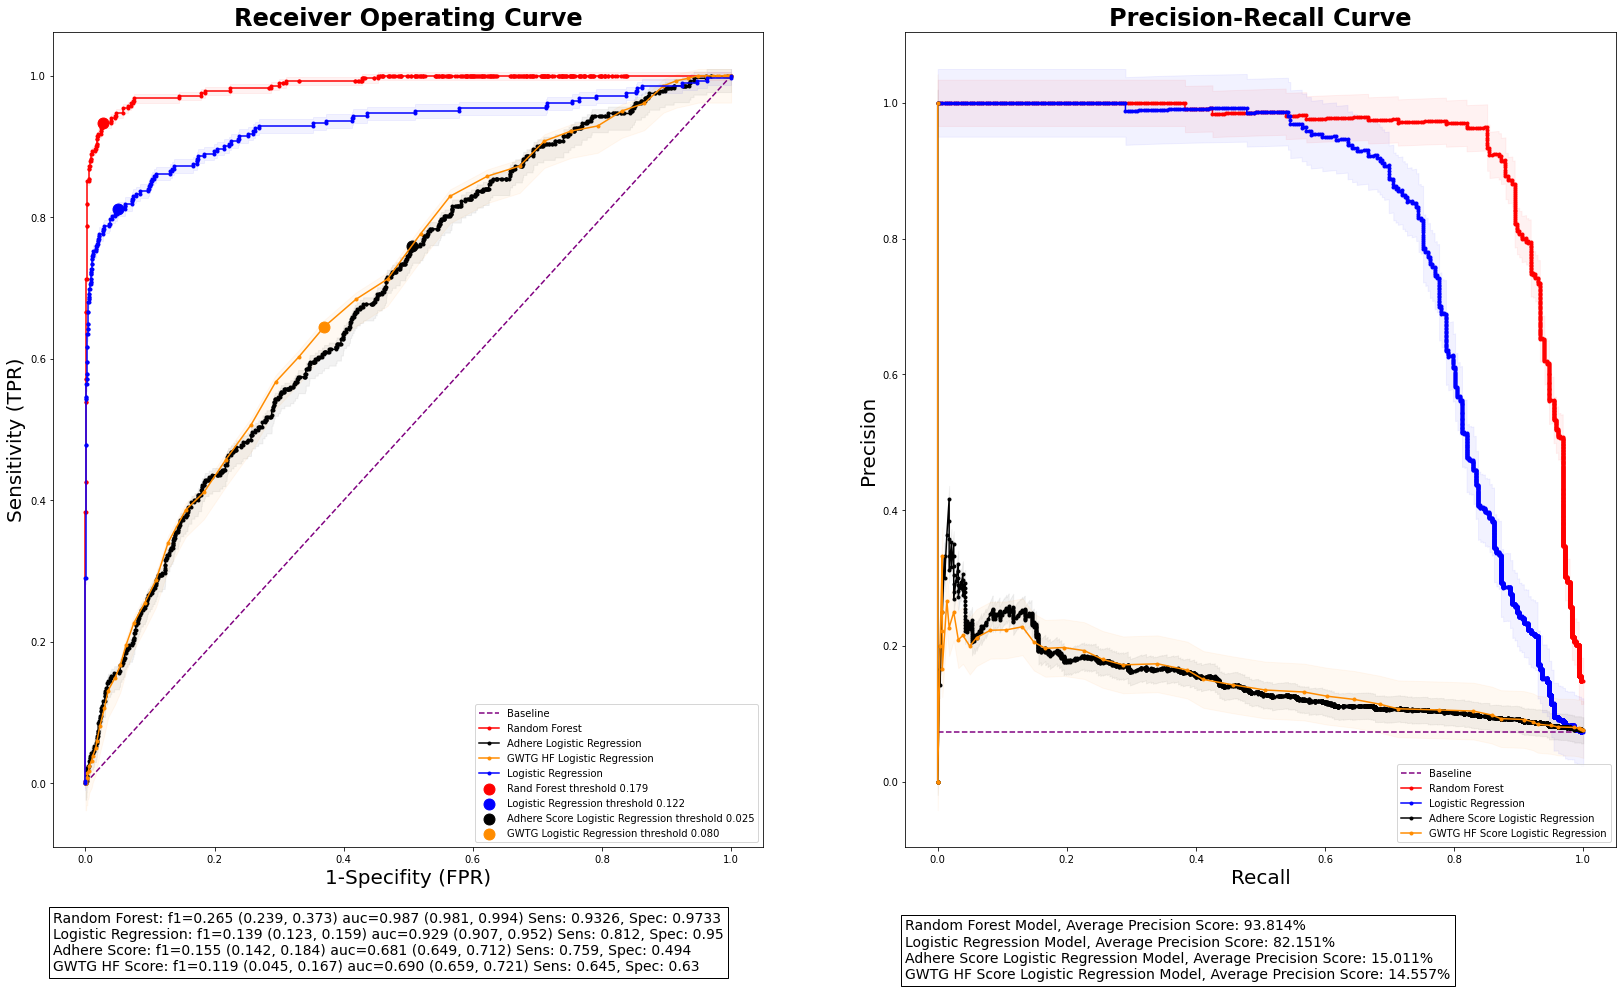

In [57]:
alpha_val=0.05
fig, axs = plt.subplots (1,2,figsize=(28,15))
# fig.suptitle("Predicting Mortality in Patients with Heart Failure", fontsize=40, fontweight='bold')

# plot the roc curve for the model
axs[0].plot(ns_fpr_rand_forest, ns_tpr_rand_forest, linestyle='--', label='Baseline', color='purple')
axs[0].plot(lr_fpr_rand_forest, lr_tpr_rand_forest, marker = '.', label='Random Forest',color='red')
axs[0].plot(lr_fpr_adhere_score_basic_regression, lr_tpr_adhere_score_basic_regression, marker = '.', label='Adhere Logistic Regression',color='black')
axs[0].plot(lr_fpr_gwtg_hf_score_basic_regression, lr_tpr_gwtg_hf_score_basic_regression, marker = '.', label='GWTG HF Logistic Regression',color='darkorange')
ci_rand_forest = alpha_val * np.std(lr_tpr_rand_forest) / np.mean(lr_tpr_rand_forest)
axs[0].fill_between(lr_fpr_rand_forest, (lr_tpr_rand_forest-ci_rand_forest),
                    (lr_tpr_rand_forest+ci_rand_forest), alpha=alpha_val,color='red')# axis labels
axs[0].plot(lr_fpr_basic_regression, lr_tpr_basic_regression, marker = '.', label='Logistic Regression', color='blue')
ci_basic_regression = alpha_val * np.std(lr_tpr_basic_regression) / np.mean(lr_tpr_basic_regression)
axs[0].fill_between(lr_fpr_basic_regression, (lr_tpr_basic_regression-ci_basic_regression),
                    (lr_tpr_basic_regression+ci_basic_regression), alpha=alpha_val,color='blue')# axis labels

ci_adhere_score_basic_regression = alpha_val * np.std(lr_tpr_adhere_score_basic_regression) / np.mean(lr_tpr_adhere_score_basic_regression)
axs[0].fill_between(lr_fpr_adhere_score_basic_regression, (lr_tpr_adhere_score_basic_regression-ci_adhere_score_basic_regression),
                    (lr_tpr_adhere_score_basic_regression+ci_basic_regression), alpha=alpha_val,color='black')# axis labels

ci_gwtg_hf_score_basic_regression = alpha_val * np.std(lr_tpr_gwtg_hf_score_basic_regression) / np.mean(lr_tpr_gwtg_hf_score_basic_regression)
axs[0].fill_between(lr_fpr_gwtg_hf_score_basic_regression, (lr_tpr_gwtg_hf_score_basic_regression-ci_gwtg_hf_score_basic_regression),
                    (lr_tpr_gwtg_hf_score_basic_regression+ci_basic_regression), alpha=alpha_val,color='darkorange')# axis labels

## leaving out deep nets due to poor performance
# axs[0].plot(lr_fpr_net_cnn, lr_tpr_net_cnn, marker = '.', label='CNN', color='salmon')
# ci_net_cnn = alpha_val * np.std(lr_tpr_net_cnn) / np.mean(lr_tpr_net_cnn)
# axs[0].fill_between(lr_fpr_net_cnn, (lr_tpr_net_cnn-ci_net_cnn),
#                     (lr_tpr_net_cnn+ci_net_cnn), alpha=alpha_val,color='salmon')# axis labels

# axs[0].plot(lr_fpr_net_lstm, lr_tpr_net_lstm, marker = '.', label='RNN', color='deeppink')
# ci_net_lstm = alpha_val * np.std(lr_tpr_net_lstm) / np.mean(lr_tpr_net_lstm)
# axs[0].fill_between(lr_fpr_net_lstm, (lr_tpr_net_lstm-ci_net_lstm),
#                     (lr_tpr_net_lstm+ci_net_lstm), alpha=alpha_val,color='deeppink')# axis labels


# axs[0].scatter(fprOpt_net_cnn,tprOpt_net_cnn, s=120, color='salmon',label = 'CNN threshold {}'.format("%.3f" % thresholdOpt_net_cnn))

# axs[0].scatter(fprOpt_net_lstm,tprOpt_net_lstm, s=120, color='hotpink',label = 'RNN threshold {}'.format("%.3f" % thresholdOpt_net_lstm))

# axs[0].plot(lr_fpr_xgboost, lr_tpr_xgboost, marker = '.', label='XGBoost',color='green')
# ci_xgboost = alpha_val * np.std(lr_tpr_basic_regression) / np.mean(lr_tpr_basic_regression)
# axs[0].fill_between(lr_fpr_xgboost, (lr_tpr_xgboost-ci_xgboost),
#                     (lr_tpr_xgboost+ci_xgboost), alpha=alpha_val,color='green')# axis labels
# axs[0].scatter(fprOpt_xgboost,tprOpt_xgboost, s=120, color='green',label = 
#                'xgBoost optimal threshold {}'.format("%.3f" % thresholdOpt_xgboost))


sensitivity_text = (('Random Forest: f1=%.3f' % (f1_rand_forest) + ' ' + str(f1_bootstrap_rand_forest) + ' auc=%.3f' % (lr_auc_rand_forest) + ' ' + str(delong_rand_forest))
    + ' ' + str(results_text_rand_forest)
    
    + '\nLogistic Regression: f1=%.3f' % (f1_basic_regression) + ' ' 
    + str(f1_bootstrap_basic_regression) + ' auc=%.3f' % (lr_auc_basic_regression) + ' ' + str(delong_reg)
    + ' ' + str(results_text_basic_regression)
    
    + '\nAdhere Score: f1=%.3f' % (f1_adhere_score_basic_regression) + ' ' 
    + str(f1_bootstrap_adhere_score_basic_regression) + ' auc=%.3f' % (lr_auc_adhere_score_basic_regression) + ' ' + str(delong_adhere)
    + ' ' + str(results_text_adhere_score_basic_regression)
   + '\nGWTG HF Score: f1=%.3f' % (f1_gwtg_hf_score_basic_regression) + ' ' 
    + str(f1_bootstrap_gwtg_hf_score_basic_regression) + ' auc=%.3f' % (lr_auc_gwtg_hf_score_basic_regression) + ' ' + str(delong_gwtg)
   + ' ' + str(results_text_gwtg_hf_score_basic_regression)
#     + '\nConvolutional Neural Network (CNN): f1=%.3f' % (lr_f1_net_cnn) + ' ' 
#     + str(f1_bootstrap_cnn) + ' auc=%.3f' % (lr_auc_net_cnn) + ' ' + str(delong_cnn)
# #    + '\n                                                                                           ' + str(results_text_net_cnn)
#     + '\nRecurrent Neural Network (RNN): f1=%.3f' % (lr_f1_net_lstm) + ' ' 
#     + str(f1_bootstrap_lstm) + ' auc=%.3f' % (lr_auc_net_lstm) + ' ' + str(delong_lstm)
#  #   + '\n                                                                                           ' + str(results_text_net_lstm)

    )
# sensitivity_text=sensitivity_text+'\nxgBoost Model: f1=%.3f auc=%.3f' % (f1_xgboost, lr_auc_xgboost)


axs[0].text(-.05, -.265, sensitivity_text, fontsize=14,
        bbox=dict(boxstyle = "square",
                  facecolor = "white"))
axs[0].scatter(fprOpt_rand_forest,tprOpt_rand_forest, s=120, color='red',label = 
               'Rand Forest threshold {}'.format("%.3f" % thresholdOpt_rand_forest))
axs[0].scatter(fprOpt_basic_regression,tprOpt_basic_regression, s=120, color='blue',label = 
               'Logistic Regression threshold {}'.format("%.3f" % thresholdOpt_basic_regression))

axs[0].scatter(fprOpt_adhere_score_basic_regression,tprOpt_adhere_score_basic_regression, s=120, color='black',label = 
               'Adhere Score Logistic Regression threshold {}'.format("%.3f" % thresholdOpt_adhere_score_basic_regression))

axs[0].scatter(fprOpt_gwtg_hf_score_basic_regression,tprOpt_gwtg_hf_score_basic_regression, s=120, color='darkorange',label = 
               'GWTG Logistic Regression threshold {}'.format("%.3f" % thresholdOpt_gwtg_hf_score_basic_regression))

axs[0].set_title('Receiver Operating Curve', fontsize=24,fontweight='bold')
axs[0].set_xlabel('1-Specifity (FPR)',fontsize=20)
axs[0].set_ylabel('Sensitivity (TPR)',fontsize=20)
# show the legend
axs[0].legend(loc='lower right')

# summarize scores
#print('Rand Forest: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
axs[1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='Baseline',color='purple')
axs[1].plot(lr_recall_rand_forest, lr_precision_rand_forest, marker = '.', label='Random Forest',color='red')
ci_rand_forest = alpha_val * np.std(lr_precision_rand_forest) / np.mean(lr_precision_rand_forest)
axs[1].fill_between(lr_recall_rand_forest, (lr_precision_rand_forest-ci_rand_forest),
                    (lr_precision_rand_forest+ci_rand_forest), alpha=alpha_val,color='red')

# axis labels
# ppurpleict class values


axs[1].plot(lr_recall_basic_regression, lr_precision_basic_regression, marker = '.', label='Logistic Regression',color='blue')
ci_basic_regression = alpha_val * np.std(lr_precision_basic_regression) / np.mean(lr_precision_basic_regression)
axs[1].fill_between(lr_recall_basic_regression, (lr_precision_basic_regression-ci_basic_regression),
                    (lr_precision_basic_regression+ci_basic_regression), alpha=alpha_val,color='blue')

# axs[1].plot(lr_recall_adhere_score_basic_regression, lr_precision_adhere_score_basic_regression, label='Adhere Score Logistic Regression',color='black')
# ci_adhere_score_basic_regression = alpha_val * np.std(lr_precision_adhere_score_basic_regression) / np.mean(lr_precision_adhere_score_basic_regression)
# axs[1].fill_between(lr_recall_adhere_score_basic_regression, (lr_precision_adhere_score_basic_regression-ci_basic_regression),
#                     (lr_precision_adhere_score_basic_regression+ci_adhere_score_basic_regression), alpha=alpha_val,color='black')

no_skill = len(y_test_adhere_score_basic_regression[y_test_adhere_score_basic_regression==1]) / len(y_test_adhere_score_basic_regression)

#axs[1].plot([0, 1], [no_skill, no_skill], marker = '.', label='Baseline',color='purple')
axs[1].plot(lr_recall_adhere_score_basic_regression, lr_precision_adhere_score_basic_regression, marker = '.', label='Adhere Score Logistic Regression',color='black')
ci_adhere_score_basic_regression = alpha_val * np.std(lr_precision_adhere_score_basic_regression) / np.mean(lr_precision_adhere_score_basic_regression)
axs[1].fill_between(lr_recall_adhere_score_basic_regression, (lr_precision_adhere_score_basic_regression-ci_adhere_score_basic_regression),
                    (lr_precision_adhere_score_basic_regression+ci_adhere_score_basic_regression), alpha=alpha_val,color='black')

no_skill = len(y_test_gwtg_hf_score_basic_regression[y_test_gwtg_hf_score_basic_regression==1]) / len(y_test_gwtg_hf_score_basic_regression)

#axs[1].plot([0, 1], [no_skill, no_skill], marker = '.', label='Baseline',color='purple')
axs[1].plot(lr_recall_gwtg_hf_score_basic_regression, lr_precision_gwtg_hf_score_basic_regression, marker = '.', label='GWTG HF Score Logistic Regression',color='darkorange')
ci_gwtg_hf_score_basic_regression = alpha_val * np.std(lr_precision_gwtg_hf_score_basic_regression) / np.mean(lr_precision_gwtg_hf_score_basic_regression)
axs[1].fill_between(lr_recall_gwtg_hf_score_basic_regression, (lr_precision_gwtg_hf_score_basic_regression-ci_gwtg_hf_score_basic_regression),
                    (lr_precision_gwtg_hf_score_basic_regression+ci_gwtg_hf_score_basic_regression), alpha=alpha_val,color='darkorange')

# axs[1].plot(lr_recall_net_cnn, lr_precision_net_cnn, marker = '.', label='CNN', color='salmon')
# ci_net_cnn = alpha_val * np.std(lr_precision_net_cnn) / np.mean(lr_precision_net_cnn)
# axs[1].fill_between(lr_recall_net_cnn, (lr_precision_net_cnn-ci_net_cnn),
#                     (lr_precision_net_cnn+ci_net_cnn), alpha=alpha_val,color='salmon')

# axs[1].plot(lr_recall_net_lstm, lr_precision_net_lstm, marker = '.', label='RNN', color='hotpink')
# ci_net_lstm = alpha_val * np.std(lr_precision_net_lstm) / np.mean(lr_precision_net_lstm)
# axs[1].fill_between(lr_recall_net_lstm, (lr_precision_net_lstm-ci_net_lstm),
#                     (lr_precision_net_lstm+ci_net_lstm), alpha=alpha_val,color='hotpink')


# axs[1].plot(lr_recall_xgboost, lr_precision_xgboost, marker = '.', label='XGBoost',color='green')
# ci_xgboost = alpha_val * np.std(lr_precision_xgboost) / np.mean(lr_precision_xgboost)
# axs[1].fill_between(lr_recall_xgboost, (lr_precision_xgboost-ci_xgboost),
#                     (lr_precision_xgboost+ci_xgboost), alpha=alpha_val,color='green')

# show the legend
axs[1].legend()

precision_recall_text=('Random Forest Model, Average Precision Score: '
                  + str("%.3f" % (average_precision_score(y_test, lr_probs_rand_forest)*100))+'%')
precision_recall_text=(precision_recall_text+'\nLogistic Regression Model, Average Precision Score: '+ 
                  str("%.3f" % (average_precision_score(y_test, lr_probs_basic_regression)*100))+'%')
precision_recall_text=(precision_recall_text+'\nAdhere Score Logistic Regression Model, Average Precision Score: '+ 
                  str("%.3f" % (average_precision_score(y_test_adhere_score_basic_regression, lr_probs_adhere_score_basic_regression)*100))+'%')
precision_recall_text=(precision_recall_text+'\nGWTG HF Score Logistic Regression Model, Average Precision Score: '+ 
                  str("%.3f" % (average_precision_score(y_test_gwtg_hf_score_basic_regression, lr_probs_gwtg_hf_score_basic_regression)*100))+'%')
# precision_recall_text=(precision_recall_text+'\nConvolutional Neural Network, Average Precision Score: '+ 
#                   str("%.3f" % (average_precision_score(y_test, lr_probs_net_cnn)*100))+'%')
# precision_recall_text=(precision_recall_text+'\nRecurrent Neural Network, Average Precision Score: '+ 
#                   str("%.3f" % (average_precision_score(y_test, lr_probs_net_lstm)*100))+'%')
# precision_recall_text=(precision_recall_text+'\n'+'XGBoost Model, Average Precision Score: '
#                   + str("%.3f" % (average_precision_score(y_test, lr_probs_xgboost)*100))+'%')

axs[1].text(-.05, -.29, precision_recall_text, fontsize=14,
        bbox=dict(boxstyle = "square",
                  facecolor = "white"))
axs[1].legend(loc='lower right')
axs[1].set_title('Precision-Recall Curve', fontsize=24,fontweight='bold')
axs[1].set_xlabel('Recall',fontsize=20)
axs[1].set_ylabel('Precision',fontsize=20)

print("")
fig.savefig('mortality_1.png')